# Visualizing the Maslov cycle and Conley-Zehnder index
In this notebook we visualize the Maslov cycle in the symplectic group and a geometric interpretation of the Conley-Zehnder index.
We use pyvista for visualization and sympy to assist in some computations.

To install pyvista with all whistles and bells, use

pip install 'pyvista[all]' jupyterlab

Interactive widgets (recommended) can be obtained by replacing 'static' in the jupyter backend by 'trame'.

In [2]:
import numpy as np
import sympy as sy
import pyvista as pv

#pv.set_jupyter_backend('trame')
pv.set_jupyter_backend('static')

# Symplectic group as solid torus
The so-called Iwasawa decomposition tells us that every symplectic $2n\times 2n$-matrix $S$ can be written as
$$
S = KAN
$$
where $K \in SO(2n) \cap Sp(2n)\cong U(n)$, $A$ is abelian subgroup (here diagonal positive hyperbolic) and $N$ is the nilpotent part.
For a $2\times 2$-symplectic matrix this just means that
$$
K= 
\left(
\begin{array}{cc}
\cos(\phi) & -\sin(\phi) \\
\sin(\phi) & \cos(\phi)
\end{array}
\right)
,
\quad
A= 
\left(
\begin{array}{cc}
a & 0 \\
0 & 1/a
\end{array}
\right)
,
\quad
N= 
\left(
\begin{array}{cc}
1 & t \\
0 & 1
\end{array}
\right)
,
$$
with $\phi \in [0,2 \pi)$, $a \in \R_{>0}$ and $t \in \R$.

The matrices $K$ form a circle and the $A$ and $N$ matrices are parametrized by the real numbers, so we can view $Sp(2)$ as a solid torus. We put this solid torus into $\R^3$ by the map
$$
(\R^2 \setminus \{ 0 \}) \times \R \to Sp(2),
\quad
(x,y;z) \mapsto K(x,y) A(z) N(x,y), 
$$
where 
$$
K(x,y) = \frac{1}{\sqrt{x^2+y^2}} \left(
\begin{array}{cc}
x & -y \\
y & x
\end{array}
\right)
,\quad
A(z)=
\left(
\begin{array}{cc}
\exp(z) & 0 \\
0 & \exp(-z)
\end{array}
\right),
\quad
N(x,y)=
\left(
\begin{array}{cc}
1 & \log(x^2 + y^2) \\
0 & 1
\end{array}
\right)
.
$$
We can squeeze this embedding more, but we will just truncate if $z$ or $\log(x^2+y^2)$ become too large. We will use pyvista's marching cubes to visualize this solid torus, which we smoothed a bit. It is helpful to see this before the Maslov cycle which sits inside this solid torus.

/tmp/ipykernel_21132/428549302.py:1: RuntimeWarning: invalid value encountered in sqrt
  NaN = np.sqrt(-1)


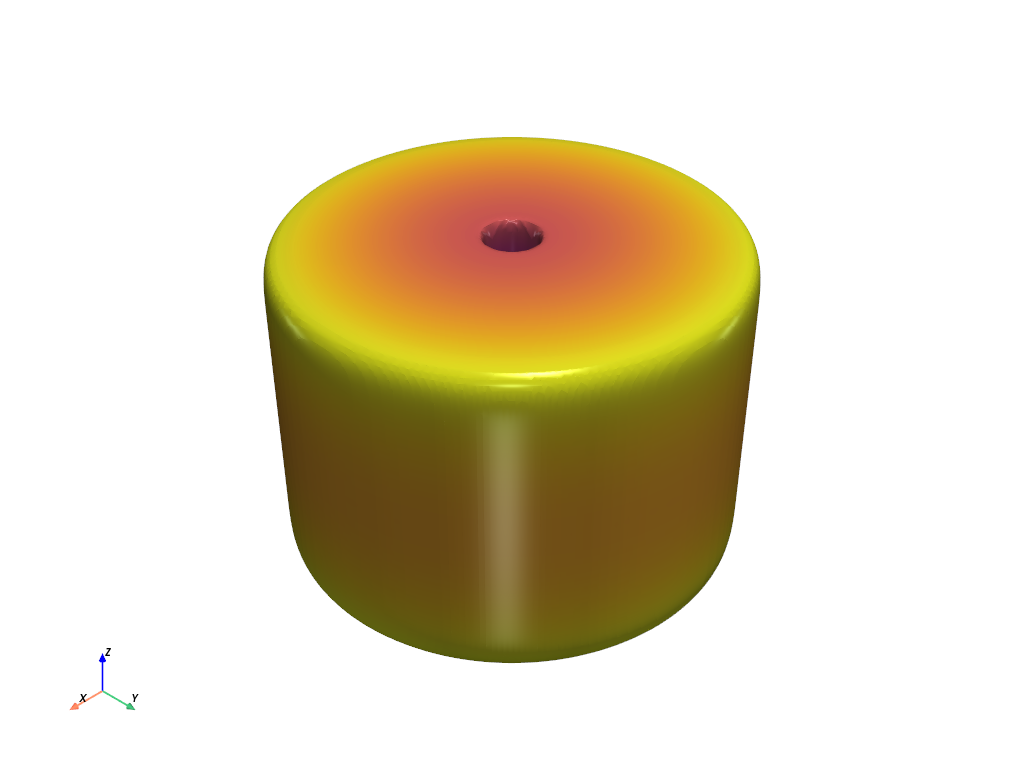

In [3]:
NaN = np.sqrt(-1)

def solid_torus(x, y, z):
    abrupt = 16
    x2 = x * x
    y2 = y * y
    x2_y2 = x2 + y2
    vals = (np.log(x**2 + y**2))**abrupt +z**abrupt-np.log(9)**abrupt+0.1
    factors = np.where(x2_y2 < 0.09, NaN, 1) * np.where(x2_y2 > 9, NaN, 1) 
    return vals #* factors

# create a uniform grid to sample the function with
n = 128
x_min, y_min, z_min = -3.1, -3.1, -3.1
grid = pv.ImageData(
    dimensions=(n, n, n),
    spacing=(abs(x_min) / n * 2, abs(y_min) / n * 2, abs(z_min) / n * 2),
    origin=(x_min, y_min, z_min),
)
x, y, z = grid.points.T

# sample and plot
values = solid_torus(x, y, z)
mesh = grid.contour([0], values, method='marching_cubes', compute_normals=True,)
dist = np.linalg.norm(mesh.points, axis=1)


mesh.plot(scalars=dist, smooth_shading=True, specular=1, cmap="plasma", show_scalar_bar=False)

We now get to the Maslov cycle. For $Sp(2)$, this is a surface given by the formula
$$
V=\{ S \in Sp(2)~|~ \det(\mathrm{id} -S)=0 \}
$$
Together with the above formula for an embedding of $Sp(2)$ into $\mathbb{R}^3$, we find an implicit description for the Maslov cycle as a subset of $\mathbb{R}^3$ (with $z$-axis removed). We compute this formula in the next cell

In [4]:
x, y, z = sy.symbols("x, y, z")
r = sy.sqrt(x*x+y*y)
f = sy.simplify( sy.Determinant( sy.Matrix([[1,0],[0,1]]) - 1/r *sy.Matrix([[x,-y],[y,x]]) * sy.Matrix([[sy.exp(z),0],[0,sy.exp(-z)]]) * sy.Matrix([[1, sy.log(r)],[0, 1]]) ) )
print(f)

(4*x**2*exp(z) - 2*x*sqrt(x**2 + y**2)*exp(2*z) - 2*x*sqrt(x**2 + y**2) + 4*y**2*exp(z) - y*sqrt(x**2 + y**2)*exp(2*z)*log(x**2 + y**2))/(2*x**2*exp(z) + 2*y**2*exp(z))


We take this formula and insert into the function below (in the vals part). The $z$-axis is missing from the domain and this causes some trouble for marching cubes. To avoid these, we cut a neighborhood of the $z$-axis. We also truncate the Maslov cycle to fit into our solid torus; the symplectic group is unbounded, so this is a convenient way to deal with this. Alternatively, we could use function like $\tan$ and $\arctan$ to fit the entire Maslov cycle into a bounded region in $\mathbb{R}^3$, but this requires more complicated formulas. 

In [5]:
def maslov_fct(x, y, z):
    x2_y2 = x * x + y * y
    vals = (4*x**2*np.exp(z) - 2*x*np.sqrt(x**2 + y**2)*np.exp(2*z) - 2*x*np.sqrt(x**2 + y**2) + 4*y**2*np.exp(z) 
            - y*np.sqrt(x**2 + y**2)*np.exp(2*z)*np.log(x**2 + y**2))/(2*x**2*np.exp(z) + 2*y**2*np.exp(z))
    factors = np.where(np.abs(np.log(x2_y2)) > np.log(9)-0.1, NaN, 1) * np.where(np.abs(z) > np.log(9)-0.1, NaN, 1) 
    return vals * factors


### Maslov cycle in Sp(2) in Euclidean space
Next we plot the Maslov cycle inside $Sp(2)$. We use a wireframe plot because of an apparent limitation of the dynamic Plotter (static Plots don't have have this problem).

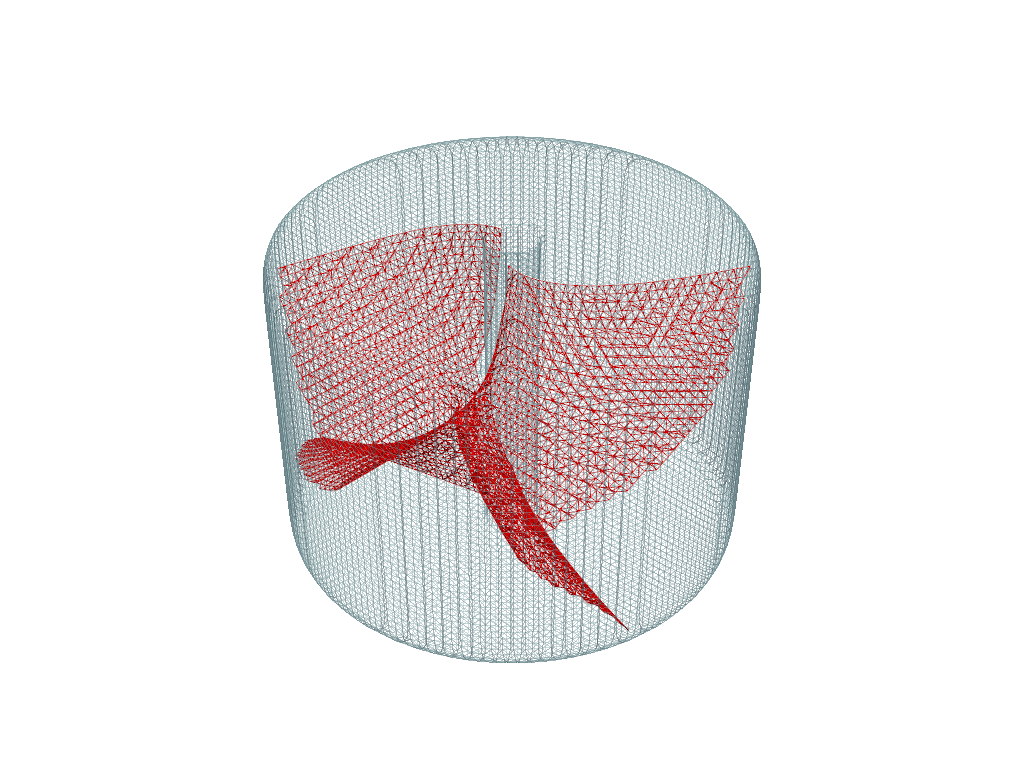

In [6]:
n = 64
x_min, y_min, z_min = -3.1, -3.1, -3.1
grid = pv.ImageData(
    dimensions=(n, n, n),
    spacing=(abs(x_min) / n * 2, abs(y_min) / n * 2, abs(z_min) / n * 2),
    origin=(x_min, y_min, z_min),
)
x, y, z = grid.points.T

values = solid_torus(x, y, z)
mesh = grid.contour([0], values, method='marching_cubes')
dist = np.linalg.norm(mesh.points, axis=1)


pl = pv.Plotter()
actor = pl.add_mesh(mesh, color='lightblue', opacity=0.25, style='wireframe')

values = maslov_fct(x, y, z)
mesh = grid.contour([0], values, method='marching_cubes')
dist = np.linalg.norm(mesh.points, axis=1)
actor = pl.add_mesh(mesh, color='red', style='wireframe')

#mesh.plot(scalars=dist, smooth_shading=True, specular=1, cmap="plasma", show_scalar_bar=False)
pl.show()
pl.close()

We can see that Maslov cycle divides $Sp(2)$ into two regions. The cone-like point in the middle is the identity matrix. Given a path of symplectic matrices starting at the identity, the Conley-Zehnder index ``counts'' the number of region changes; this statement is a little vague because of the role of singular points (the identity matrix here) of the Maslov cycle.  

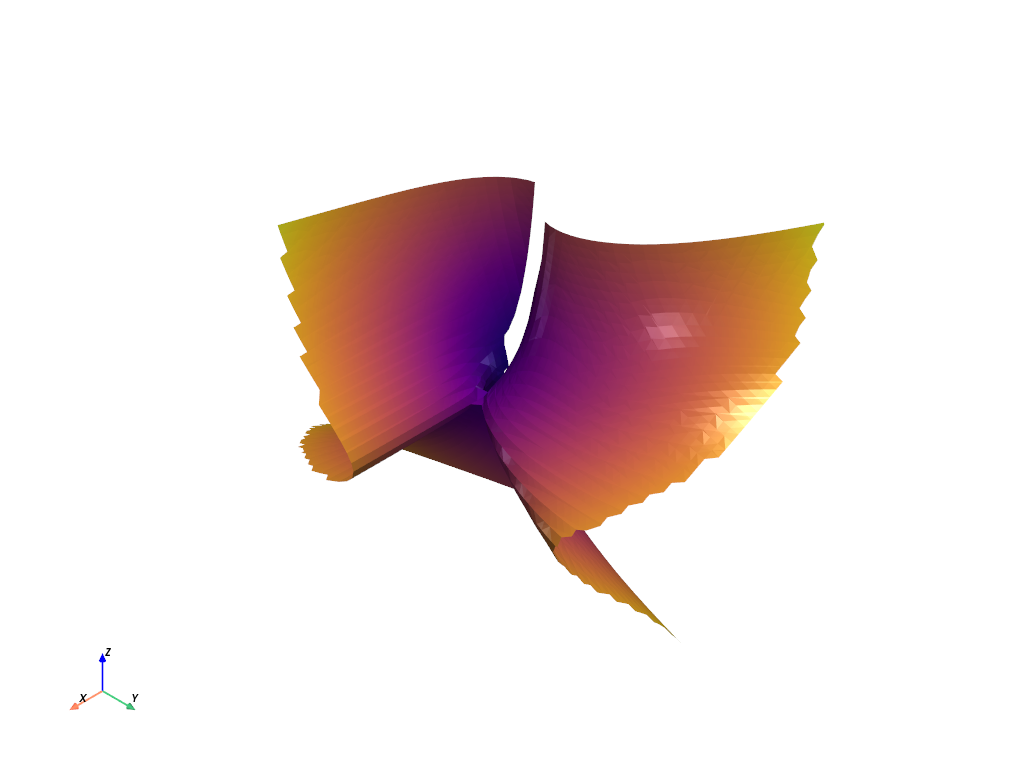

In [7]:
mesh.plot(scalars=dist, specular=1, cmap="plasma", show_scalar_bar=False)


In the next plot we see the path
$$
t\mapsto
\left(
\begin{array}{cc}
\cos(t) & -\sin(t) \\
\sin(t) & \cos(t)
\end{array}
\right) 
\text{ for }t\in [0,5].
$$
This path has Conley-Zehnder index $1$. This cell have to be executed to display in a new window.

In [8]:
n = 64 #increase for better resolution
x_min, y_min, z_min = -3.1, -3.1, -3.1
grid = pv.ImageData(
    dimensions=(n, n, n),
    spacing=(abs(x_min) / n * 2, abs(y_min) / n * 2, abs(z_min) / n * 2),
    origin=(x_min, y_min, z_min),
)
x, y, z = grid.points.T

pl = pv.Plotter(notebook=False)

values = maslov_fct(x, y, z)
mesh = grid.contour([0], values, method='marching_cubes')
dist = np.linalg.norm(mesh.points, axis=1)
actor = pl.add_mesh(mesh, color='red', opacity=0.6)

points = np.array([[np.cos(t/1000), np.sin(t/1000),0] for t in range(5000)])
actor = pl.add_lines(points, color='black', width=5 )


pl.show()
pl.close()